# Foundations of Data Mining: Assignment 4

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

**Deadline:** Thursday, April 12, 2018

In [1]:
# Please fill in your names here
NAME_STUDENT_1 = "Iggy Van Hoof"
NAME_STUDENT_2 = "Ylja Remmits"

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all"

###### Backpropagation (6 points)

Figure 1 illustrates a simple neural network model.

![Figure 1](images/a4_network.png)

It has single input $x$, and three layers with respectively one, two, and one neurons. The activation function of the neurons is ReLU. 

The parameters $w_1$, $w_2$, $w_3$, $w_4$, and $w_5$ (no biases) are initialized to the following values $w_1 = 2, w_2 = 1$, $w_3 = 2$, $w_4 = 4$, and $w_5 = 1$. Implement a single update step of the gradient descent algorithm by hand. Run the update state for the data point $(x=2, y=3)$:

The goal is to model the relationship between two continuous variables. The learning rate is set to $0.1$

Provide the solution in the following format:

- A choice for a loss function 
- Compute graph for training the neural network
- Partial derivative expression for each of the parameters in the model
- The update expression for each of the parameters for each of the data-points
- The final value of all five parameters after the single step in the gradient descent algorithm

The Python code for simple computational graph nodes, as seen in the tutorial session, is provided in the cell below (run the cell to load the code, and again to run the code). Extend the nodes so they can be used to implement the network described above. Implement the network with the same initial weights and the correct learning rate, and verify your hand-made calculations. Add comments to your code or provide a separate description to explain the changes you have made.

In [2]:
# %load basic_graph.py
'''
Implementations of nodes for a computation graph. Each node
has a forward pass and a backward pass function, allowing
for the evaluation and backpropagation of data.
'''

from abc import ABC, abstractmethod
import math
import time


class Node(object):

    def __init__(self, inputs):
        self.inputs = inputs

    @abstractmethod
    def forward(self):
        ''' Feed-forward the result '''
        raise NotImplementedError("Missing forward-propagation method.")

    @abstractmethod
    def backward(self, d):
        ''' Back-propagate the error
            d is the delta of the subsequent node in the network '''
        raise NotImplementedError("Missing back-propagation method.")


class ConstantNode(Node):

    def __init__(self, value):
        self.output = value

    def forward(self):
        return self.output

    def backward(self, d):
        pass


class VariableNode(Node):

    def __init__(self, value):
        self.output = value

    def forward(self):
        return self.output

    def backward(self, d):
        self.output -= 0.1 * d # Gradient Descent


class AdditionNode(Node):

    def forward(self):
        self.output = sum([i.forward() for i in self.inputs])
        return self.output

    def backward(self, d):
        for i in self.inputs:
            i.backward(d)


class MultiplicationNode(Node):

    def forward(self):
        self.output = self.inputs[0].forward() * self.inputs[1].forward()
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * self.inputs[1].output)
        self.inputs[1].backward(d * self.inputs[0].output)


class MSENode(Node):

    def forward(self):
        self.output = 0.5 * (
            self.inputs[0].forward() - self.inputs[1].forward())**2
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * (self.inputs[0].output - self.inputs[1].output))
        self.inputs[1].backward(d * (self.inputs[1].output - self.inputs[0].output))


class SigmoidNode(Node):

    def forward(self):
        self.output = 1.0 / (1.0 + math.exp(-self.inputs[0].forward()))
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * self.output * (1.0 - self.output))

class ReLUNode(Node):

    def forward(self):
        self.output = max(0, self.inputs[0].forward())
        return self.output

    def backward(self, d):
        if self.output > 0:
            self.inputs[0].backward(d*1)
        else:
            self.inputs[0].backward(d*0)

class TanhNode(object):

    def forward(self):
        raise NotImplementedError("Forward pass for tanh activation node has not been implemented yet.")

    def backward(self, d):
        raise NotImplementedError("Backward pass for tanh activation node has not been implemented yet.")

# Example graph as shown in MLP lecture slides
class SampleGraph(object):

    def __init__(self, x, y, w, b):
        ''' x: input
            y: expected output
            w: initial weight
            b: initial bias '''
        self.w = VariableNode(w)
        self.b = VariableNode(b)
        self.graph = MSENode([
            AdditionNode([
                MultiplicationNode([
                    ConstantNode(x),
                    self.w
                ]),
                MultiplicationNode([
                    self.b,
                    ConstantNode(1)
                ])
            ]),
            ConstantNode(y)
        ])

    def forward(self):
        return self.graph.forward()

    def backward(self, d):
        self.graph.backward(d)


class Neuron(Node):

    def __init__(self, inputs, weights, activation):
        ''' weights: list of initial weights, same length as inputs '''
        self.inputs = inputs
        # Initialize a weight for each input
        self.weights = [VariableNode(weight) for weight in weights]
        # Neurons normally have a bias, ignore for this assignment
        #self.bias = VariableNode(bias, "b")

        # Multiplication node for each pair of inputs and weights
        mults = [MultiplicationNode([i, w]) for i, w, in zip(self.inputs, self.weights)]
        # Neurons normally have a bias, ignore for this assignment
        #mults.append(MultiplicationNode([self.bias, ConstantNode(1)]))

        # Sum all multiplication results
        added = AdditionNode(mults)

        # Apply activation function
        if activation == 'sigmoid':
            self.graph = SigmoidNode([added])
        elif activation == 'relu':
            self.graph = ReLUNode([added])
        elif activation == 'tanh':
            self.graph = TanhNode([added])
        else:
            raise ValueError("Unknown activation function.")

    def forward(self):
        self.output = self.graph.forward()
        return self.output

    def backward(self, d):
        self.graph.backward(d)

    def set_weights(self, new_weights):
        for i in len(new_weights):
            self.weights[i].output = new_weights[i]

    def get_weights(self):
        return [weight.output for weight in self.weights]

if __name__ == '__main__':
    print("Loaded simple graph nodes")
    inputs = [ConstantNode(2)]
    n1 = Neuron(inputs, [2], 'relu')
    o1 = n1.forward()
    print(o1)
    n2 = Neuron([n1], [1], 'relu')
    n3 = Neuron([n1], [2], 'relu')
    o2 = n2.forward()
    print(o2)
    o3 = n3.forward()
    print(o3)
    n4 = Neuron([n2, n3], [4, 1], 'relu')
    o4 = n4.forward()
    print(o4)
    mse = MSENode([n4, ConstantNode(3)])
    print(mse.forward())
    gMSE = mse.backward(1)
    print("w4 & w5: {}".format(n4.get_weights()))
    print("W2: {}".format(n2.get_weights()))
    print("W3: {}".format(n3.get_weights()))
    print("W1: {}".format(n1.get_weights()))

#     g4 = n4.backward(gMSE)
#     n3.backward(g4)

    
    # Example network
#     sg = SampleGraph(2, 2, 2, 1)
#     prediction = sg.forward()
#     print("Initial prediction is", prediction)
#     sg.backward(1)
#     print("w has new value", sg.w.output)
#     print("b has new value", sg.b.output)

    # Run your network here

'\nImplementations of nodes for a computation graph. Each node\nhas a forward pass and a backward pass function, allowing\nfor the evaluation and backpropagation of data.\n'

Loaded simple graph nodes
4
4
8
24
220.5
w4 & w5: [-4.4, -15.8]
W2: [-32.6]
W3: [-6.4]
W1: [-23.200000000000003]


In [1]:
# Code 1


#### Uitleg


## Training Deep Models (3 points)

The model in the example code below performs poorly as its depth increases. Train this model on the MNIST digit detection task. 

Examine its training performance by gradually increasing its depth:
- Set the depth to 1 hidden layer
- Set the depth to 2 hidden layers
- Set the depth to 3 hidden layers

Modify the model such that you improve its performance when its depth increases. Train the new model again for the different depths:
- Set the depth to 1 hidden layer
- Set the depth to 2 hidden layers
- Set the depth to 3 hidden layers

Submit an explanation for the limitation of the original model. Explain your modification. 
Submit your code and 6 plots (can be overlaid) for the training performance of both models with different depths. 



In [4]:
# (You don't need to change this part of the code)
from __future__ import print_function
import numpy as np
np.random.seed(1234)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils


import matplotlib.pyplot as plt

batch_size = 128
nb_classes = 10
nb_epoch = 10

Using TensorFlow backend.


In [5]:
# (You don't need to change this part of the code)
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

11493376/11490434 [==============================] - 4s 0us/step
60000 train samples
10000 test samples


In [16]:
# Use this parameter to change the depth of the model
number_hidden_layers_max = 3  # Number of hidden layers

In [29]:
# Model
scores = []
histories = []
scores2 = []
histories2 = []
for i in range(1,number_hidden_layers_max+1):
    model = Sequential()
    model.add(Dense(512, input_shape=(784,), activation='relu'))
    model.add(Dropout(0.2))
    
    number_hidden_layers = i
    while number_hidden_layers > 1:
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
        number_hidden_layers -= 1


    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),
                  metrics=['accuracy'])

    
    histories.append(model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test)))
    scores.append(model.evaluate(X_test, Y_test, verbose=0))
    
    model = Sequential()
    model.add(Dense(512, input_shape=(784,), activation='sigmoid'))
    model.add(Dropout(0.2))
    
    number_hidden_layers = i
    while number_hidden_layers > 1:
        model.add(Dense(512))
        model.add(Activation('sigmoid'))
        model.add(Dropout(0.2))
        number_hidden_layers -= 1


    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),
                  metrics=['accuracy'])

    
    histories2.append(model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test)))
    scores2.append(model.evaluate(X_test, Y_test, verbose=0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_24 (Activation)   (None, 10)                0         
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 85us/step - loss: 1.1240 - acc: 0.7259 - val_loss: 0.6029 - val_acc: 0.8627
Epoch 2/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 142us/step - loss: 2.3248 - acc: 0.1222 - val_loss: 2.2313 - val_acc: 0.2139
Epoch 2/10
60000/60000 [==============================] - 8s 138us/step - loss: 2.2461 - acc: 0.1739 - val_loss: 2.1451 - val_acc: 0.5404
Epoch 3/10
60000/60000 [==============================] - 9s 146us/step - loss: 2.1536 - acc: 0.2430 - val_loss: 2.0385 - val_acc: 0.5214
Epoch 4/10
60000/60000 [==============================] - 9s 150us/step - loss: 2.0268 - acc: 0.3315 - val_loss: 1.8758 - val_acc: 0.6571
Epoch 5/10
60000/60000 [==============================] - 8s 141us/step - loss: 1.8537 - acc: 0.4266 - val_loss: 1.6661 - val_acc: 0.6530
Epoch 6/10
60000/60000 [==============================] - 9s 144us/step - loss: 1.6459 - acc: 0.5045 - val_loss: 1.4399 - val_acc: 0.6892
Epoch 7/10
60000/60000 [==============================] - 9s 152us/step - loss: 1.4392 - acc: 0.5664 - val_loss: 1.2368 - 

Test score for relu, 1 layers: 0.2578225689917803
Test accuracy for relu, 1 layers: 0.9291
Test score for sigmoid, 1 layers: 0.4662249247550964
Test accuracy for sigmoid, 1 layers: 0.8823
Test score for relu, 2 layers: 0.20841597146093846
Test accuracy for relu, 2 layers: 0.9403
Test score for sigmoid, 2 layers: 0.8617151197433471
Test accuracy for sigmoid, 2 layers: 0.7899
Test score for relu, 3 layers: 0.17753258088752627
Test accuracy for relu, 3 layers: 0.9462
Test score for sigmoid, 3 layers: 2.239799889373779
Test accuracy for sigmoid, 3 layers: 0.1639


History data for relu:
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
History data for sigmoid:
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


History data for relu:
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
History data for sigmoid:
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


History data for relu:
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
History data for sigmoid:
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

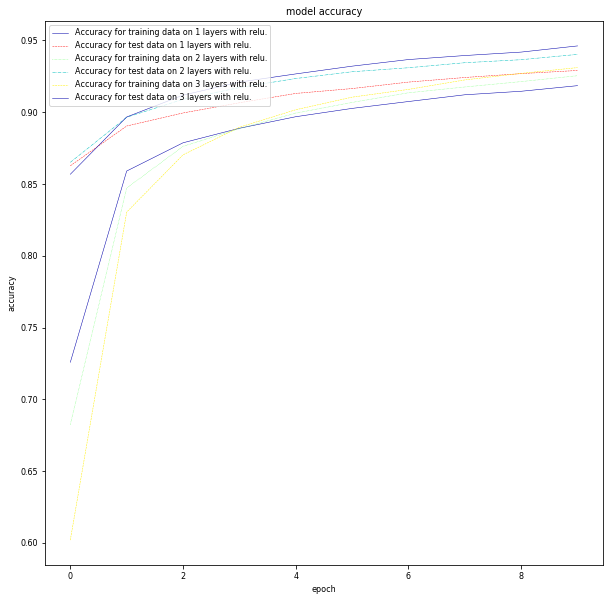

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

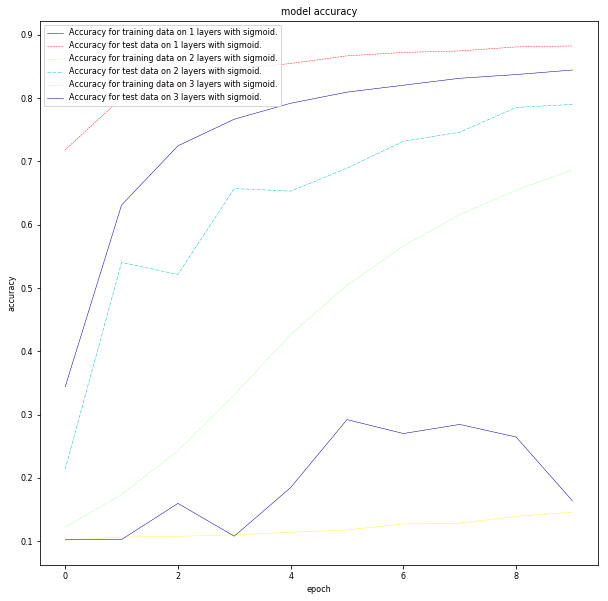

In [35]:
# Training (You don't need to change this part of the code)
for i in range(3):
    print('Test score for relu, {} layers: {}'.format(i+1, scores[i][0]))
    print('Test accuracy for relu, {} layers: {}'.format(i+1, scores[i][1]))
    print('Test score for sigmoid, {} layers: {}'.format(i+1, scores2[i][0]))
    print('Test accuracy for sigmoid, {} layers: {}'.format(i+1, scores2[i][1]))

plt.figure(figsize=(10,10))
for i in range(len(histories)):
    # list all data in history
    print("History data for relu:")
    print(histories[i].history.keys())
    print("History data for sigmoid:")
    print(histories2[i].history.keys())
    # summarize history for accuracy
    plt.plot(histories[i].history['acc'], label = "Accuracy for training data on {} layers with relu.".format(i+1))
    plt.plot(histories[i].history['val_acc'], label = "Accuracy for test data on {} layers with relu.".format(i+1))

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(histories)):
    plt.plot(histories2[i].history['acc'], label = "Accuracy for training data on {} layers with sigmoid.".format(i+1))
    plt.plot(histories2[i].history['val_acc'], label = "Accuracy for test data on {} layers with sigmoid.".format(i+1))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [2]:
# Code opdracht 2

#### UItleg


## MNIST Calculator (6 points)

During the lectures you have seen a CNN model that can be successfully trained to classify the MNIST images. You have also seen how a RNN model that can be trained to implement addition of two numbers. You now need to build a model that is a combination of convolutional layers and recurrent cells. 

Using the KERAS library, design and train a model that produces a sum of a sequence of MNIST images. More specifically, the model should input a sequence of 10 images and compute the cumulative sum of the digits represented by the images.

For example:

Input 1: ![294](images/a3ex1.png)

Output 1: 46

Input 2: ![61](images/a3ex2.png)

Output 2: 43

Your solutions should include:
- Python code that formats the MNIST dataset such that it can be used for traning and testing your model
- Implementation in keras of your model (for training and testing)
- Performance on the model on test data
- Justification (in text) of your decisions for the model architecture (type of layers, activation functions, loss function, regularization and training hyperparameters)

Note: Use the 60000/10000 train/test split of the MNIST dataset


In [7]:
# Provide your solution here

##### Provide your justification here